# Feb 24th, 2022 (grant finalize)

**Motivation**: Finalizing figures for the grant. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

## Fig dir

In [3]:
fig_dir = pjoin(tmp_dir, 'fig_grant')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [4]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.65), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'perc': 'p10-sample',
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_base).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

ids

[0, 1, 2, 3, 4]

## 2 x anim memship plot

In [6]:
sub = 8
i = sub - 1
proj_ca = gr_ca.project_vec(gr_ca.anim_pi[i])
proj_bold = gr_bold.project_vec(gr_bold.anim_pi[i])

In [7]:
tr_ca = gr_bold.trim2d(proj_ca)
tr_bold = gr_bold.trim2d(proj_bold)

In [8]:
min_thres = 0.2

vmax_1 = np.max(np.abs(
    proj_bold['top'].reshape(len(proj_bold['top']), -1)
), axis=-1)
vmax_2 = np.nanmax(np.abs(
    proj_ca['top'].reshape(len(proj_ca['top']), -1)
), axis=-1)
vmax_1, vmax_2 = map(
    lambda x: max(x[:-1]),
    [vmax_1[:-1], vmax_2[:-1]],
)
vmin = min_thres

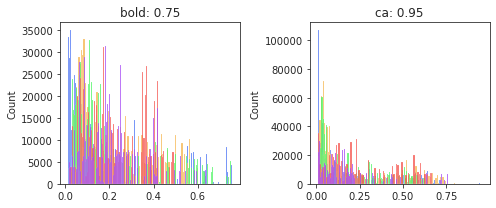

In [9]:
fig, axes = create_figure(1, 2, (7, 3))
for i in range(5):
    x = proj_bold['top'][i]
    sns.histplot(x[x.nonzero()], color=gr_ca.colors[i + 1], ax=axes[0])
    axes[0].set_title(f'bold: {vmax_1:0.2f}')
    
    x = proj_ca['top'][i]
    sns.histplot(x[x.nonzero()], color=gr_ca.colors[i + 1], ax=axes[1])
    axes[1].set_title(f'ca: {vmax_2:0.2f}')

In [10]:
cm_candidates = ['OrRd', 'YlOrRd', 'PuRd', 'RdPu', 'plasma', 'inferno', 'magma', 'copper']

In [10]:
vmax_1 = vmax_2 = 0.8

In [11]:
figs, sups = [], []
for cm in cm_candidates:
    fig, axes = create_figure(2, 7, (10, 3.3), width_ratios=[0.15] + [1] * 6)
    for i in range(1, 5 + 2):
        x2plt = np.ma.masked_where(tr_bold['top'] == 0, tr_bold['top'])
        axes[0, i].imshow(x2plt, cmap='Greys_r')

        x2plt = tr_bold['proj-top'][i - 1]
        if i == 6:
            x2plt = np.ma.masked_where(x2plt == 0, x2plt)
            axes[0, i].imshow(x2plt, cmap=gr_bold.cmaps[-1])
        else:
            x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
            im = axes[0, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax_1)
            if i == 1:
                plt.colorbar(im, cax=axes[0, 0])

        x2plt = np.ma.masked_where(tr_ca['top'] == 0, tr_ca['top'])
        axes[1, i].imshow(x2plt, cmap='Greys_r')

        x2plt = tr_ca['proj-top'][i - 1]
        if i == 6:
            x2plt = np.ma.masked_where(x2plt == 0, x2plt)
            axes[1, i].imshow(x2plt, cmap=gr_ca.cmaps[-1])
        else:
            x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
            im = axes[1, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax_2)
            if i == 1:
                plt.colorbar(im, cax=axes[1, 0])
    for i in range(2):
        axes[i, 0].yaxis.set_ticks_position('left')
        axes[i, 0].tick_params(labelsize=10.) 
    remove_ticks(axes)
    sup = fig.suptitle(cm, fontsize=17, y=1.01)
    figs.append(fig)
    sups.append(sup)
    plt.close()

In [12]:
save_fig(figs, sups, pjoin(fig_dir, 'top_cmaps.pdf'), multi=True)

In [13]:
vmin = 0.2
vmax = 0.8
cm = 'magma'

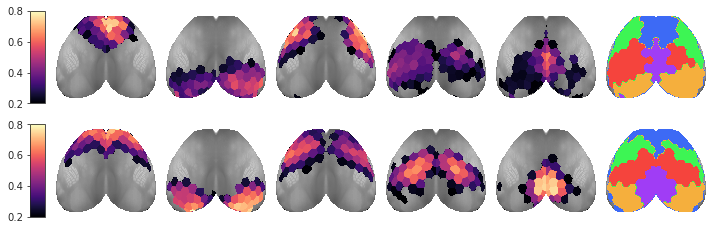

In [15]:
fig, axes = create_figure(2, 7, (10, 3.3), width_ratios=[0.15] + [1] * 6)
for i in range(1, 5 + 2):
    x2plt = np.ma.masked_where(tr_bold['top'] == 0, tr_bold['top'])
    axes[0, i].imshow(x2plt, cmap='Greys_r')

    x2plt = tr_bold['proj-top'][i - 1]
    x2plt = gaussian_filter(x2plt, sigma=1)
    if i == 6:
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        axes[0, i].imshow(x2plt, cmap=gr_bold.cmaps[-1])
    else:
        x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
        im = axes[0, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax)
        if i == 1:
            plt.colorbar(im, cax=axes[0, 0])

    x2plt = np.ma.masked_where(tr_ca['top'] == 0, tr_ca['top'])
    axes[1, i].imshow(x2plt, cmap='Greys_r')

    x2plt = tr_ca['proj-top'][i - 1]
    x2plt = gaussian_filter(x2plt, sigma=1)
    if i == 6:
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        axes[1, i].imshow(x2plt, cmap=gr_ca.cmaps[-1])
    else:
        x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
        im = axes[1, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax, interpolation='none')
        if i == 1:
            plt.colorbar(im, cax=axes[1, 0])
for i in range(2):
    axes[i, 0].yaxis.set_ticks_position('left')
    axes[i, 0].tick_params(labelsize=10.) 
remove_ticks(axes)

In [39]:
interp = 'antialiased'
vmin = 0.2
vmax = 0.9
cm = 'magma'

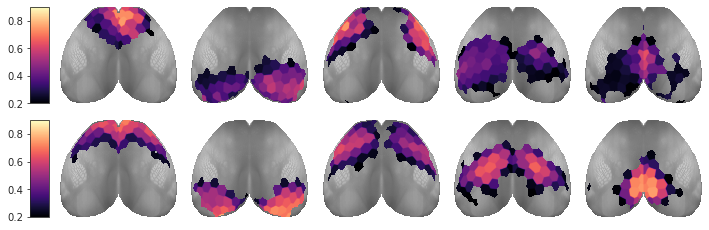

In [40]:
fig, axes = create_figure(2, 6, (10, 3.3), width_ratios=[0.15] + [1] * 5)
for i in range(1, 5 + 1):
    x2plt = np.ma.masked_where(tr_bold['top'] == 0, tr_bold['top'])
    axes[0, i].imshow(x2plt, cmap='Greys_r')

    x2plt = tr_bold['proj-top'][i - 1]
    if i == 6:
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        axes[0, i].imshow(x2plt, cmap=gr_bold.cmaps[-1])
    else:
        if interp != 'none':
            x2plt = gaussian_filter(x2plt, sigma=1)
        x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
        im = axes[0, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax, interpolation=interp)
        if i == 1:
            cbar = plt.colorbar(im, cax=axes[0, 0])

    x2plt = np.ma.masked_where(tr_ca['top'] == 0, tr_ca['top'])
    axes[1, i].imshow(x2plt, cmap='Greys_r')

    x2plt = tr_ca['proj-top'][i - 1]
    if i == 6:
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        axes[1, i].imshow(x2plt, cmap=gr_ca.cmaps[-1])
    else:
        if interp != 'none':
            x2plt = gaussian_filter(x2plt, sigma=1)
        x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
        im = axes[1, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax, interpolation=interp)
        if i == 1:
            cbar = plt.colorbar(im, cax=axes[1, 0])
for i in range(2):
    axes[i, 0].yaxis.set_ticks_position('left')
    axes[i, 0].tick_params(labelsize=10.) 
remove_ticks(axes)

for dpi in [100, 300, 600]:
    figname = f"{mice.get_key(sub)}_cbar-[{vmin:0.2f},{vmax:0.2f}]_interpolation-{interp}_dpi{dpi}.png"
    fig.savefig(
        pjoin(fig_dir, figname),
        dpi=dpi, bbox_inches='tight')

plt.show()

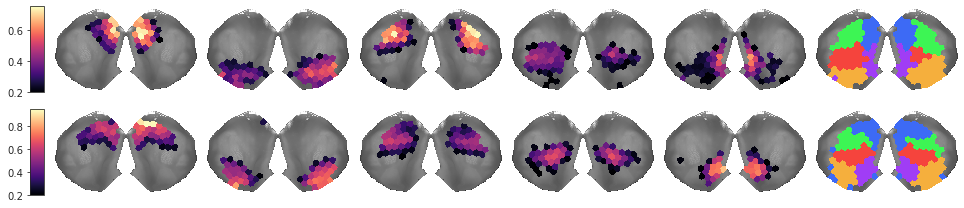

In [17]:
fig, axes = create_figure(2, 7, (13.5, 3), width_ratios=[0.1] + [1] * 6)
for i in range(1, 5 + 2):
    x2plt = np.ma.masked_where(tr_bold['flat'] == 0, tr_bold['flat'])
    axes[0, i].imshow(x2plt, cmap='Greys_r')
    
    x2plt = tr_bold['proj-flat'][i - 1]
    if i == 6:
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        axes[0, i].imshow(x2plt, cmap=gr_bold.cmaps[-1])
    else:
        x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
        im = axes[0, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax_1)
        if i == 1:
            plt.colorbar(im, cax=axes[0, 0])

    x2plt = np.ma.masked_where(tr_ca['flat'] == 0, tr_ca['flat'])
    axes[1, i].imshow(x2plt, cmap='Greys_r')
    
    x2plt = tr_ca['proj-flat'][i - 1]
    if i == 6:
        x2plt = np.ma.masked_where(x2plt == 0, x2plt)
        axes[1, i].imshow(x2plt, cmap=gr_ca.cmaps[-1])
    else:
        x2plt = np.ma.masked_where(x2plt < min_thres, x2plt)
        im = axes[1, i].imshow(x2plt, cmap=cm, vmin=vmin, vmax=vmax_2)
        if i == 1:
            plt.colorbar(im, cax=axes[1, 0])
for i in range(2):
    axes[i, 0].yaxis.set_ticks_position('left')
    axes[i, 0].tick_params(labelsize=10.) 
remove_ticks(axes)
for dpi in [100, 300, 600]:
    figname = f"{mice.get_key(sub)}_flat_[0.2,0.8]_dpi{dpi}.png"
    fig.savefig(
        pjoin(fig_dir, figname),
        dpi=dpi, bbox_inches='tight')
plt.show()

## Proportion without inset

In [14]:
dims = {'sub': 10, 'ses': 3, 'run': 4}

props_mean = {
    'marker': 'o',
    'markerfacecolor': 'white',
    'markeredgecolor': 'k',
    'markersize': 8,
    'alpha': 1.0,
}
props_swarm = {
    'size': 4,
    'alpha': 0.7,
    'linewidth': 0.4,
    'zorder': 0,
}

In [15]:
b_anim = bootstrap(
    x=gr_bold.run_cut_prune,
    n_resamples=int(1e4),
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_boot = bn.nanstd(b_anim, 0, ddof=1)

In [16]:
df_bold = gr_bold.mk_boot_df(se_boot, gr_bold.run_cut_prune, group=False)

In [17]:
for anim in range(10):
    if anim + 1 != 8:
        continue
    figs, sups, axes, axes_inset = plot_proportions(
        df=df_bold.loc[df_bold['subject'] == anim + 1],
        # inset_data=b_anim[:, anim, :, -1].T,
        save_file=pjoin(fig_dir, f"indiv_bold-lite_{mice.get_key(anim + 1)}_{now()}.pdf"),
        ylim=(0, 100),
        props_mean=props_mean,
        props_swarm=props_swarm,
        line_scale=1.,
        xlabel_fontsize=13,
        ylabel_fontsize=13,
        xtick_labelsize=11,
        ytick_labelsize=11,
        figsize_y=3.1,
        nrows=1,
    )
    for f, ci in zip(figs, [95, 99, 99.9]):
        f.suptitle('')
        for dpi in [100, 300, 600]:
            figname = pjoin(fig_dir, f'indiv_bold-lite_sub-SLC08_ci{ci}_dpi{dpi}.png')
            f.savefig(figname, bbox_inches='tight', dpi=dpi)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_grant/indiv_bold-lite_sub-SLC08_(2022_02_20).pdf

done.

In [18]:
b_anim = bootstrap(
    x=gr_ca.run_cut_prune,
    n_resamples=int(1e4),
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_boot = bn.nanstd(b_anim, 0, ddof=1)

In [19]:
df_ca = gr_ca.mk_boot_df(se_boot, gr_ca.run_cut_prune, group=False)

In [20]:
for anim in range(10):
    if anim + 1 != 8:
        continue
    figs, sups, axes, axes_inset = plot_proportions(
        df=df_ca.loc[df_ca['subject'] == anim + 1],
        # inset_data=b_anim[:, anim, :, -1].T,
        save_file=pjoin(fig_dir, f"indiv_ca2_{mice.get_key(anim + 1)}_{now()}.pdf"),
        ylim=(0, 100),
        props_mean=props_mean,
        props_swarm=props_swarm,
        line_scale=1.,
        xlabel_fontsize=13,
        ylabel_fontsize=13,
        xtick_labelsize=11,
        ytick_labelsize=11,
        figsize_y=3.1,
        nrows=1,
    )
    for f, ci in zip(figs, [95, 99, 99.9]):
        f.suptitle('')
        for dpi in [100, 300, 600]:
            figname = pjoin(fig_dir, f'indiv_ca2_sub-SLC08_ci{ci}_dpi{dpi}.png')
            f.savefig(figname, bbox_inches='tight', dpi=dpi)

/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp/fig_grant/indiv_ca2_sub-SLC08_(2022_02_20).pdf

done.

## OLD

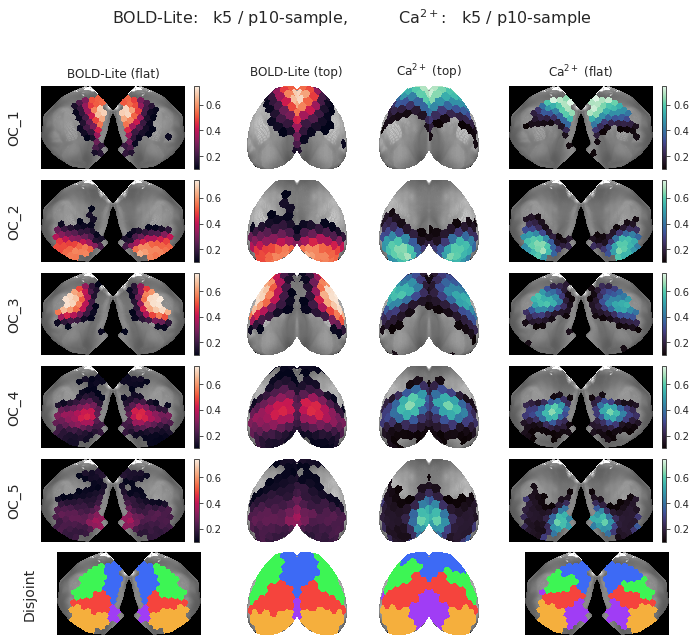

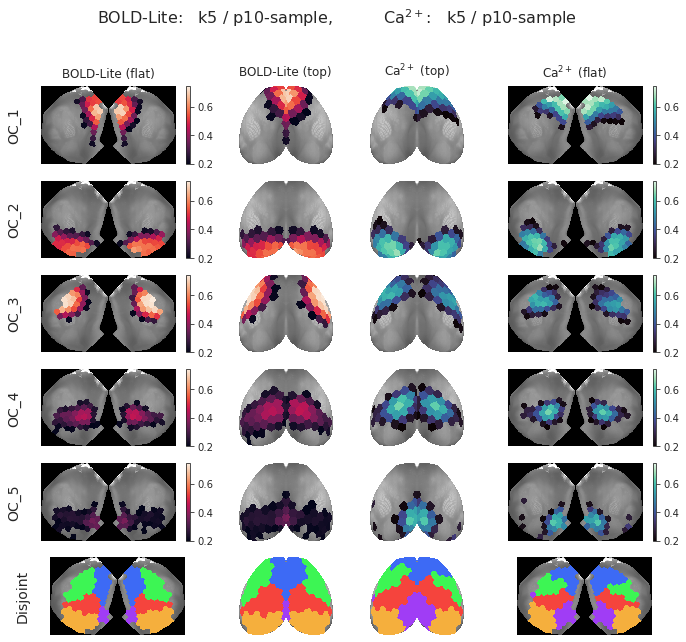

In [18]:
proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    min_thres=0.1,
    fix_cmap=True,
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

display(fig)


proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    min_thres=0.2,
    fix_cmap=True,
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

display(fig)

In [20]:
for thres in [0.1, 0.15, 0.2]:
    proj_bold = gr_bold.project_vec()
    proj_ca = gr_ca.project_vec()
    fig, _ = gr_ca.show(
        proj_bold, proj_ca,
        labels=('BOLD-Lite', r'Ca$^{2+}$'),
        cmaps=('rocket', 'mako'),
        min_thres=thres,
        fix_cmap=True,
        display=False,
    )
    sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
    sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
    sup = fig.suptitle(sup, fontsize=16, y=1.02)

    fig.savefig(pjoin(fig_dir, f"thres{thres:0.2f}_group.png"), bbox_inches='tight', dpi=200)
    plt.close()
    
    for i, sub in enumerate(mice.cfg.sub_ids):
        k = mice.get_key(sub)
        proj_ca = gr_ca.project_vec(gr_ca.anim_pi[i])
        proj_bold = gr_bold.project_vec(gr_bold.anim_pi[i])

        fig, _ = gr_ca.show(
            proj_bold, proj_ca,
            labels=('BOLD-Lite', r'Ca$^{2+}$'),
            cmaps=('rocket', 'mako'),
            min_thres=thres,
            fix_cmap=True,
            display=False,
        )
        sup = f'{k}\n'
        sup += f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
        sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
        sup = fig.suptitle(sup, fontsize=16, y=1.02)

        fig.savefig(pjoin(fig_dir, f"thres{thres:0.2f}_{k}.png"), bbox_inches='tight', dpi=200)
        plt.close()